In [118]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassPredictionError

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score

In [4]:
df = pd.read_csv('winequality.csv', delimiter=';')

In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
df.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

Acho que é importante no começo dar uma olhada nas variáveis, por exemplo a variável quality não tá uniformemente distribuída entre todas as notas (o que é esperado).

In [17]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,9.000000


Aparentemente tem algo de errado na variável alcohol. Algumas variáveis parecem ter outliers, principalmente density.

In [19]:
al = df.alcohol.astype(float)

ValueError: could not convert string to float: '128.933.333.333.333'

Mantive o código e o erro acima pra ficar claro o problema da variável alcohol: algumas linhas estão com formatação estranha como 128.933.333.333.333. Vou usar to_numeric() e colocar errors='force' pra tansformar esses casos em NaN (e depois remove-los). Eu poderia tentar transformar esses casos em algum outro valor, mas como eu não conheço o domínio do problema e nem como a variável alcohol foi escrita pra esse csv, eu prefiro remover. Por exemplo, o 12.893.333 seria 12.8 ? Provável mas não sei ao certo.

In [20]:
df.alcohol = pd.to_numeric(df.alcohol, errors='coerce')

In [21]:
df.isnull().sum()

type                     0
fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar           0
chlorides                0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       0
sulphates                0
alcohol                 40
quality                  0
dtype: int64

40 valores vão ser removidos, de 6498 linhas, da menos de 1%

In [176]:
df2 = df.dropna()
print(len(df2))

6457


In [31]:
df2.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Vamos ver os outliers agora, uma maneira de visualizar rapidamente é com boxplot:

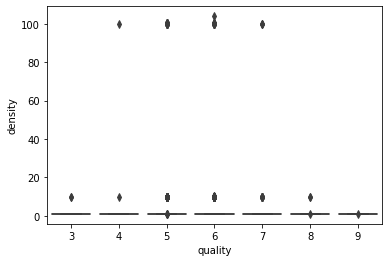

In [42]:
sbn.boxplot('quality', 'density', data = df2)

Realmente os outliers são bem grosseiros.

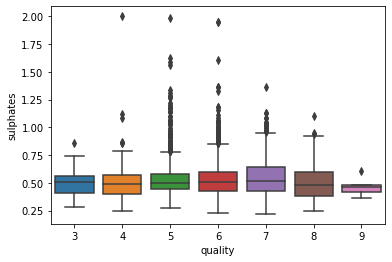

In [46]:
sbn.boxplot('quality', 'sulphates', data = df2)

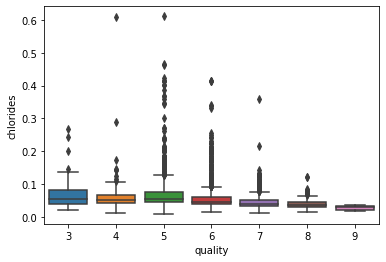

In [47]:
sbn.boxplot('quality', 'chlorides', data = df2)

Essa variável também parece ter outliers, mas não são como o das outras variáveis que parecem erro de digitação de tão grosseiros. 

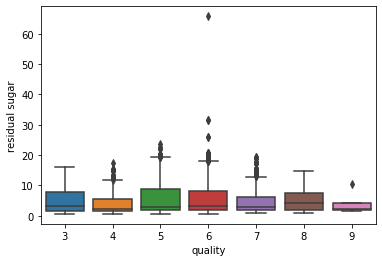

In [48]:
sbn.boxplot('quality', 'residual sugar', data = df2)

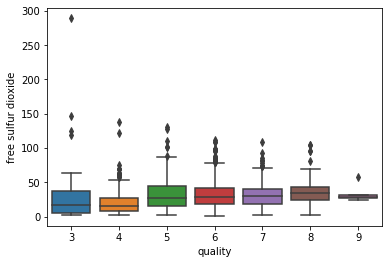

In [50]:
sbn.boxplot('quality', 'free sulfur dioxide', data = df2)

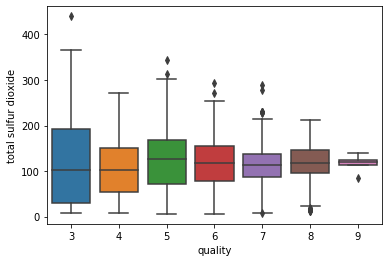

In [51]:
sbn.boxplot('quality', 'total sulfur dioxide', data = df2)

In [49]:
df.describe(percentiles=[.25, .5, .75,.90, .95, .99])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6457.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268,10.489083,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806,1.192961,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
90%,8.800000,0.590000,0.490000,13.000000,0.086000,54.000000,188.000000,0.998400,3.420000,0.720000,12.300000,7.000000
95%,9.800000,0.670000,0.560000,15.000000,0.102000,61.000000,206.000000,0.999392,3.500000,0.790000,12.700000,7.000000
99%,12.000000,0.880000,0.740000,18.200000,0.186160,77.000000,238.000000,10.008000,3.640000,0.990000,13.400000,8.000000


Coloquei mais percentis, veja que density tá em 0.999 pro percentil 95% e depois pula pra 10.008 no 99% e depois 103.89 como maior valor. Provavelmente outliers. pH por exemplo, parece bem factível. Decidi que vou remover o percentil 99% de densidade, o residual sugar e free sulfur dioxide, mas os outros vou manter. Acho que dependeria um pouco de conhecimento de domínio nesse caso também. Por exemplo, acho que um especialista em vinhos saberia dizer se chlorides acima de 0.1 é algo outlier ou não. No caso da density, vendo o boxplot e os percentis, tem um salto muito artificial nos valores. Eu poderia usar algum outro método para detecção de outliers? Poderia, por exemplo usar dbscan, mas acho que visualmente pelo boxplot e avaliando os percentis já ficou bem visível o que é outlier (mais uma vez, conhecimento do domínio ajudaria também).

In [177]:
print(len(df2))
df2.drop(df2.loc[df2['density']>=9].index, inplace=True)
df2.drop(df2.loc[df2['residual sugar']>=60].index, inplace=True)
df2.drop(df2.loc[df2['free sulfur dioxide']>=400].index, inplace=True)
print(len(df2))

6457


C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


6321


Blz, até agora limpamos a alcohol, removemos NAs(só tiveram 40 depois que converti alcohol), removemos alguns outliers que identificamso via boxplot/medidas estatísticas. Não temos mais missing data. Preciso transformar o tipo de vinho em variável numérica e vou fazer isso usando get_dummies e então acho que podemos partir para os modelos agora. Ainda vou usar um standard scaler pra deixar os dados na mesma faixa. Uma outra etapa de pre-processamento que poderiamos fazer seria combinação de variáveis mas só vou ver isso depois dos resultados dos modelos. Acho que talvez tenha um problema de dataset não balanceado devido a falta de exemplos de notas 3 e 9 (veja histograma abaixo). 

(array([  30.,  216.,    0., 2129.,    0., 2815., 1069.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <a list of 10 Patch objects>)

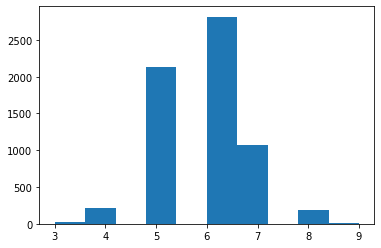

In [35]:
plt.hist(df2.quality)

In [187]:
df2['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

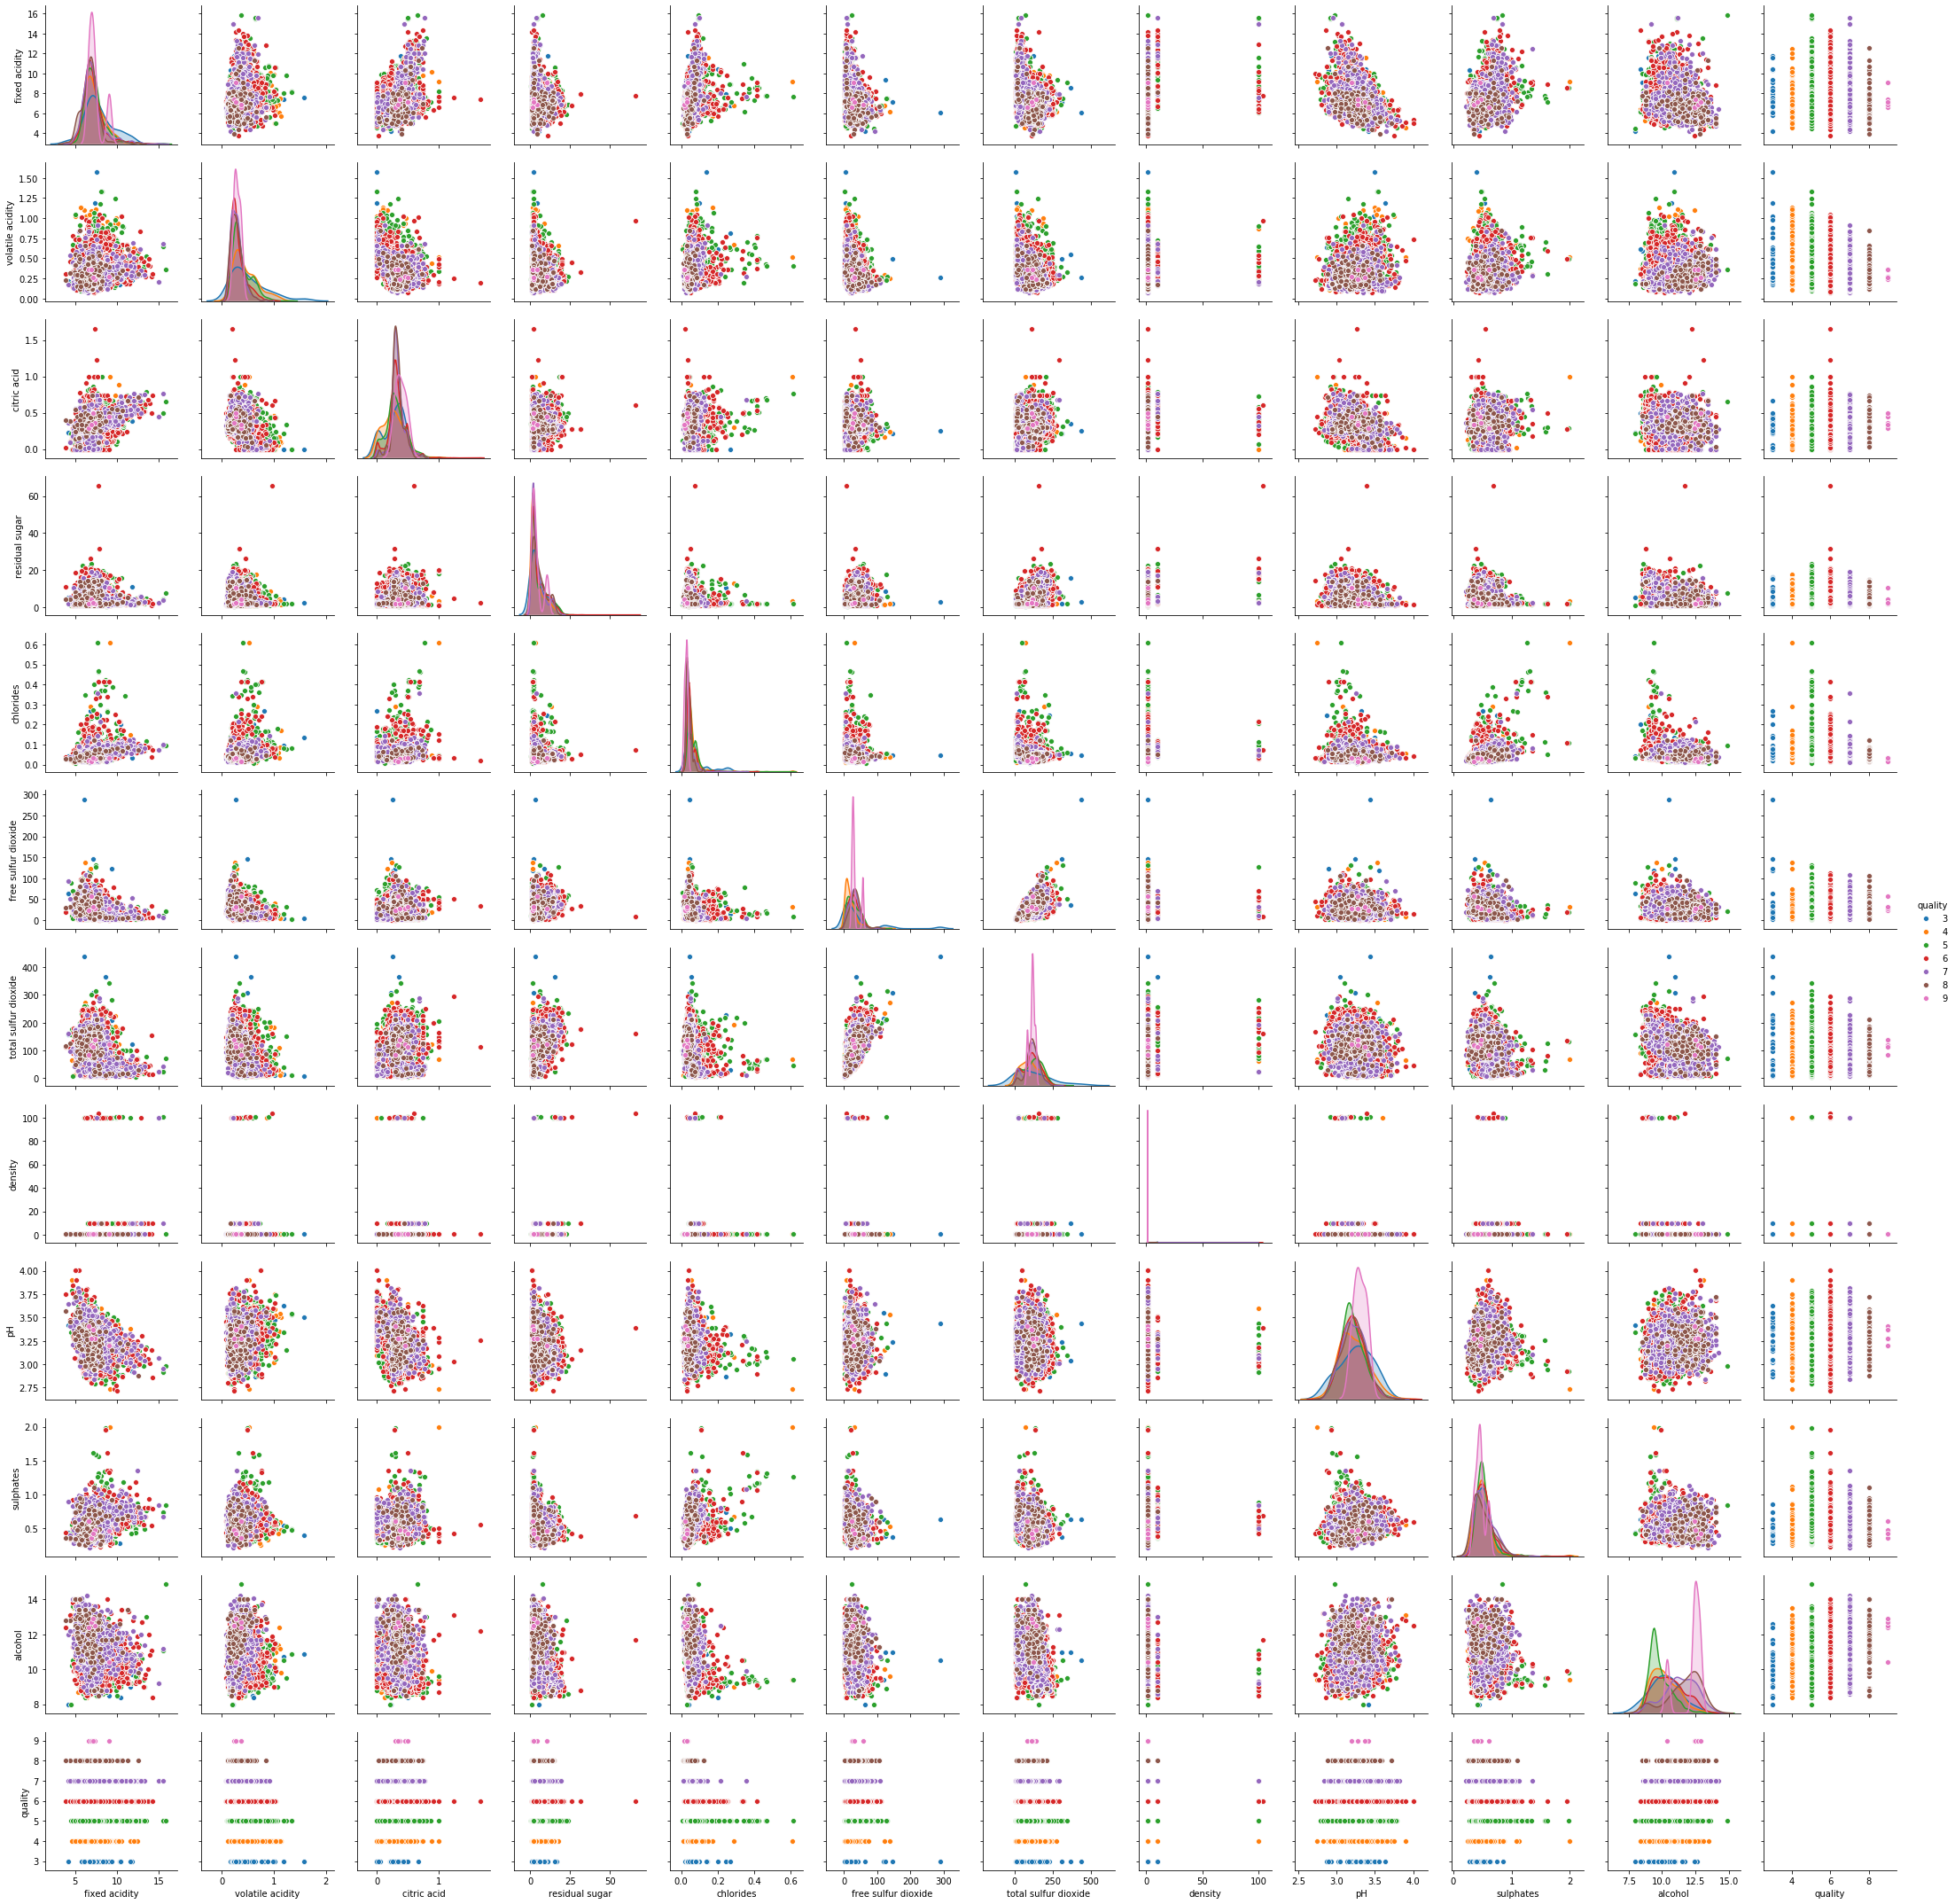

In [37]:
sbn.pairplot(df2, hue='quality')
plt.show()

Por esse pairplot não é possível dizer que alguma variável explicaria sozinha a qualidade, então se algum modelo conseguir aprender será através da combinação das variáveis. 

In [188]:
df3 =  shuffle(df2)
df3 = pd.get_dummies(df3)

Fiz um shuffle porque as primeiras linhas são sempre do tipo branco e as últimas de vermelho. Só pra ter certeza que quando particionar o dataset não vai ficar mais de um tipo que do outro.

In [189]:
df3.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_Red,type_White
4702,6.4,0.69,0.09,7.6,0.044,34.0,144.0,0.99480,3.26,0.38,10.1,6,0,1
4366,5.9,0.29,0.28,3.2,0.035,16.0,117.0,0.98959,3.26,0.42,12.6,6,0,1
5273,11.5,0.54,0.71,4.4,0.124,6.0,15.0,0.99840,3.01,0.83,11.8,7,1,0
4088,7.3,0.25,0.27,3.8,0.047,16.0,79.0,0.99173,3.07,0.46,11.3,6,0,1
4465,6.6,0.26,0.56,15.4,0.053,32.0,141.0,0.99810,3.11,0.49,9.3,5,0,1


In [190]:
y = df3['quality']
df3.drop(columns=['quality'], inplace=True)
variables = df3.columns
x = df3.iloc[:,:]

In [191]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify=y) #vou estratificar pelo y

In [192]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Gosto de começar com modelos simples, vou testar uma ridge regression e um lasso. Depois posso ver outros modelos mais complexos.

In [193]:
#meio que fiz o gridsearch na mao pro parametro alpha
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
rmse = []
for a in alphas:
    error = np.sqrt(-cross_val_score(Ridge(alpha=a), X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    rmse.append( error.mean() )

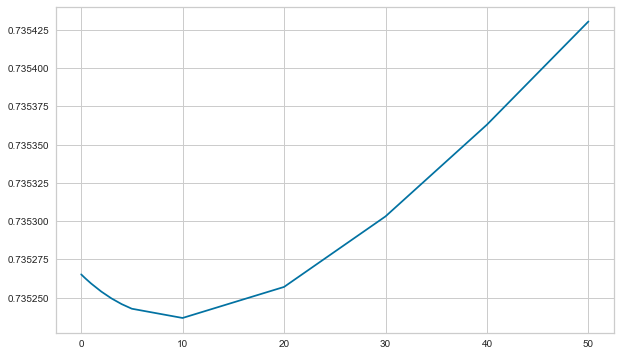

In [194]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.plot(alphas, rmse)

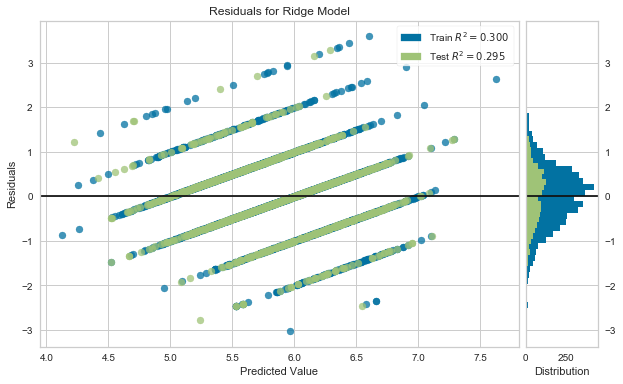

In [195]:
model1 = Ridge(alpha=10)
visualizer = ResidualsPlot(model1)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

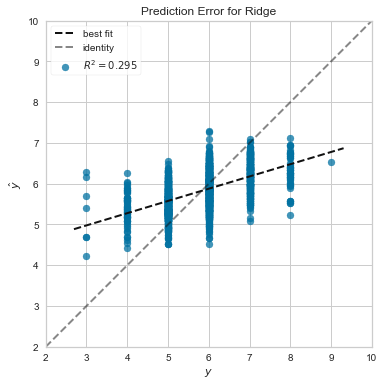

In [196]:
visualizer = PredictionError(model1)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
visualizer.poof() 

Ficou bem ruim.

In [197]:
model2 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=20000, cv=5).fit(X_train, y_train)

In [198]:
error = np.sqrt(-cross_val_score(model2, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
print(error.mean() )

0.7352618430233074


Uma vantagem do lasso é saber o quanto cada variável importa na predição. Por exemplo as variáveis type_White, citric acid, chlorides estão com peso muito baixo.

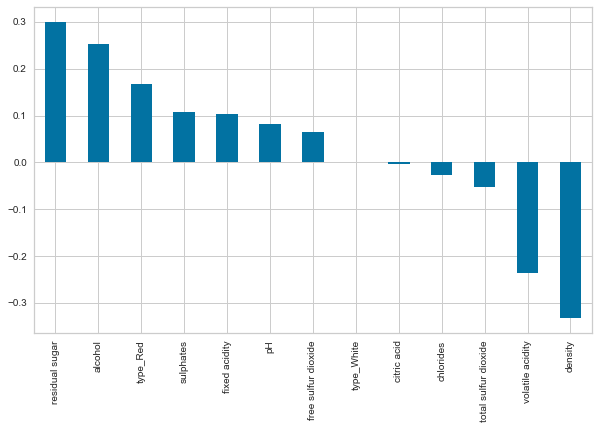

In [199]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
coef = pd.Series(model2.coef_, variables)
coef.sort_values(inplace = True,  ascending=False)
coef.plot(kind = "bar")

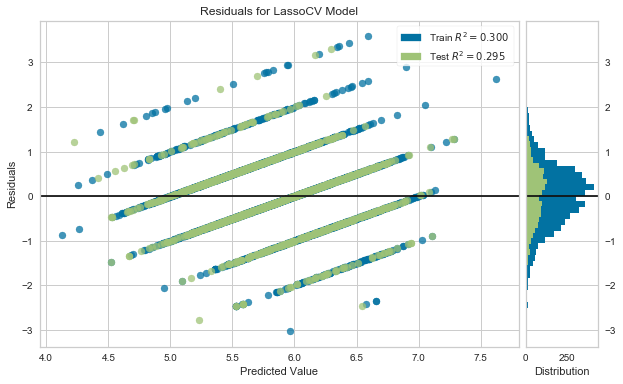

In [200]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
visualizer = ResidualsPlot(model2)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

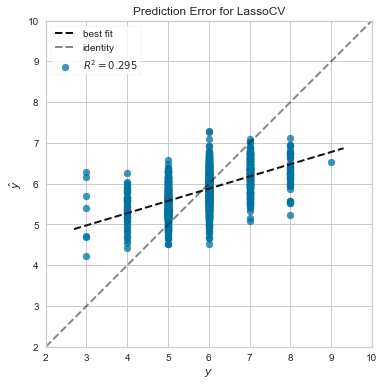

In [201]:
visualizer = PredictionError(model2)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
visualizer.poof()   

Blz, interpretando um pouco esses gráficos: o prediction error, mostra no eixo X o valor real de y e no eixo y o valor estimado pelo modelo. No caso note que tem uma variância bem grande nas previsões, por exemplo, pra nota 4 real (y), o modelo previu de 4.1 até 6.5. A coisa fica pior para os casos com poucos exemplos, como o 9 e o 3, no caso do 9, foi previsto 6.5 e para o 3 variou de 4.6 até 6.5. O r^2 também ficou bem ruim e nos gráficos dos resíduos podemos ver que eles estão longe de uma normal. Tem algumas estratégias que podemos seguir: (i) fazer um classificador para red e outro para white types, (ii) usar algum método para reamostragem ou uma função de custo diferente com penalidade maior para os erros dos exemplos 9 e 3 (iii) tratar como um problema de classificação em que cada nota é um label (não acredito que vá mudar muita coisa no final) (iv) agrupar as notas em categorias como: baixa 3-4, média:5-7, alta 8-9 ou algo do tipo e usar algum classificador.

In [203]:
#criei um bocado de classificadores com parametros default pra ver como fica o desempenho ao invés de usar regressão.
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
tree_pred = decision_tree.predict(X_test)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

KN = KNeighborsClassifier()
KN.fit(X_train,y_train)
KN_pred = KN.predict(X_test)

Gaussian = GaussianNB()
Gaussian.fit(X_train,y_train)
Gaussian_pred = Gaussian.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
svc_pred = svc.predict(X_test)


C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [204]:
print('Decision Tree:', accuracy_score(y_test, tree_pred)*100,'%')
print('Random Forest:', accuracy_score(y_test, rf_pred)*100,'%')
print('KNeighbors:',accuracy_score(y_test, KN_pred)*100,'%')
print('GaussianNB:',accuracy_score(y_test, Gaussian_pred)*100,'%')
print('SVC:',accuracy_score(y_test, svc_pred)*100,'%')


Decision Tree: 56.29348513598988 %
Random Forest: 63.25110689437066 %
KNeighbors: 56.35673624288425 %
GaussianNB: 22.074636306135357 %
SVC: 56.103731815306766 %


Parece que a Random Forest obteve um resultado melhor, então vamos dar uma explorada:

C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


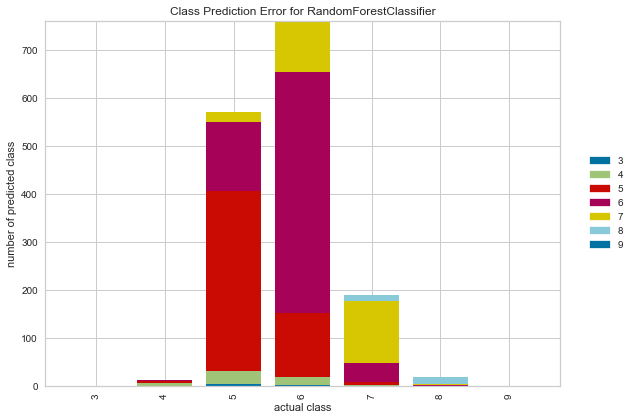

In [205]:
visualizer = ClassPredictionError(RandomForestClassifier(random_state=42))

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

O gráfico acima mostra como as classes estão sendo previstas, note que a classe 5 e 6 possuem bastante acertos e os erros são quase sempre para notas adjacentes, por isso que a estratégia de unir as notas pode ser uma boa.

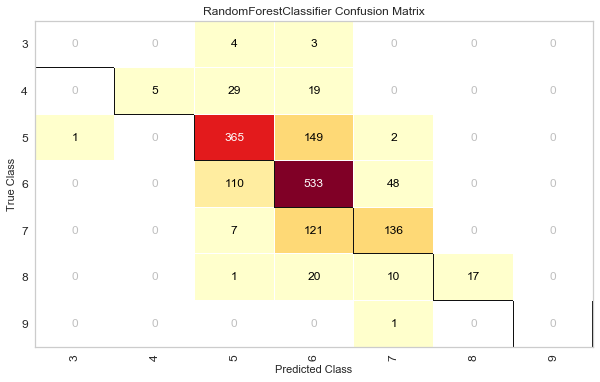

In [206]:
cm = ConfusionMatrix(RandomForestClassifier(random_state=42, n_estimators=100))

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

Acho que a matriz de confusão deixa um pouco mais claro o que está acontecendo, as classes 5, 6 e 7 são as com maior número de exemplos e acertos, mas a maior parte dos erros são para as classes vizinhas, note que a classe 6 tem 545 acertos, mas 260 erros para as classes 5 e 7. Vou tentar usar métodos para datasets desbalanceados e ver se melhora alguma coisa.

In [207]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                 sampling_strategy='auto',
                                 replacement=False,
                                 random_state=0)
bbc.fit(X_train, y_train) 
y_pred = bbc.predict(X_test)
balanced_accuracy_score(y_test, y_pred) 

0.32685797356980373

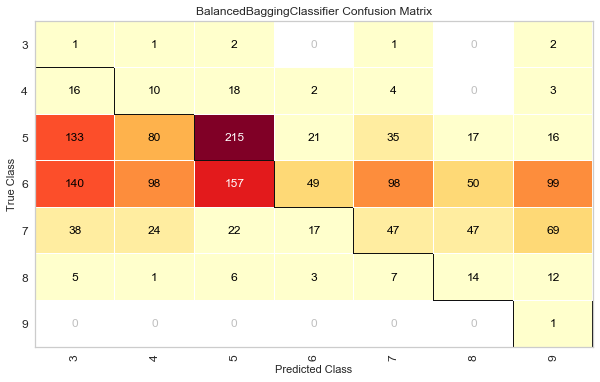

In [208]:
cm = ConfusionMatrix(bbc)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [127]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train) 

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.33601810249866987

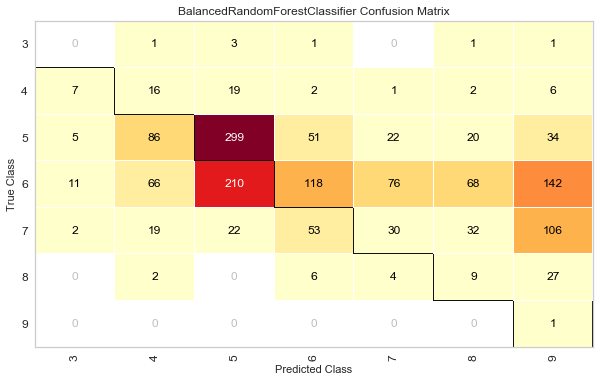

In [128]:
cm = ConfusionMatrix(brf)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [129]:

eec = EasyEnsembleClassifier(random_state=0)
eec.fit(X_train, y_train) 
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)  

0.31875403809248326

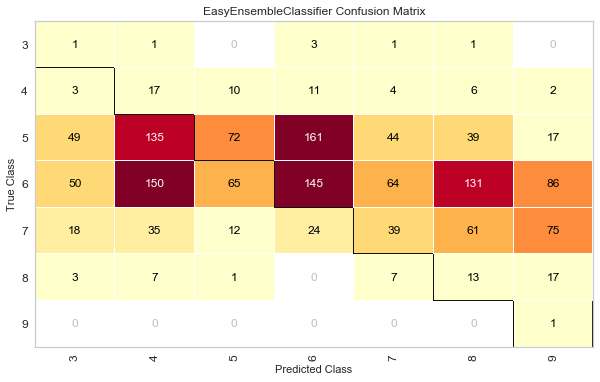

In [130]:
cm = ConfusionMatrix(eec)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

Testei algumas opções para datasets desbalanceados mas elas se msotraram inuteis pois o acerto que deu nas classes sub-representadas (3 e 9) nao valeu a pena em relação ao erro que aumentou nas outras classes. Resolvi usar o t-SNE para projetar os dados em um plano e ver se aparecem clusters naturalmente no dataset

In [163]:

X_embedded = TSNE(n_components=2, init='pca').fit_transform( StandardScaler().fit_transform(df3))

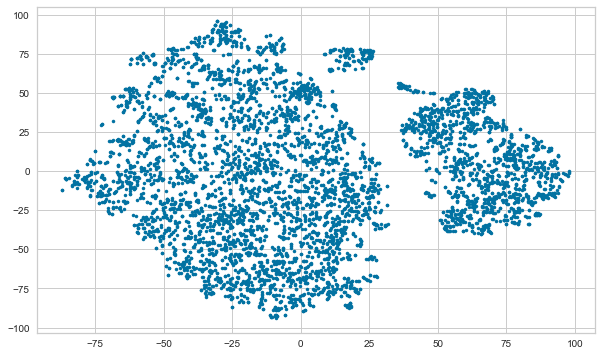

In [164]:
plt.plot(X_embedded[:,0], X_embedded[:,1], '.')

In [165]:
df_tsne = df2[ df2['type'] == 'Red' ]
color = df_tsne['quality']
df_tsne.drop(columns=['type', 'quality'], inplace=True)
X_embedded = TSNE(n_components=2, init='pca').fit_transform( StandardScaler().fit_transform(df_tsne) )

C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


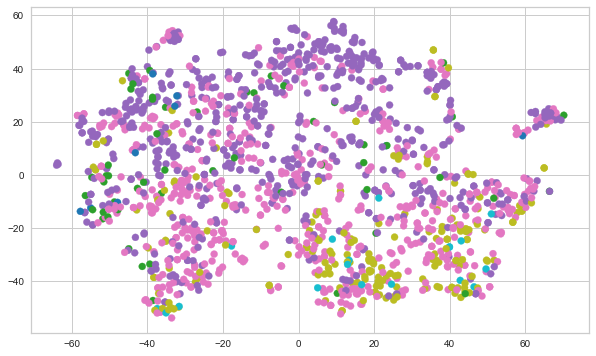

In [168]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color, cmap='tab10')

Parece que não tem nenhum cluster muito claro, ao menos usando o t-sne e mesmo considerando apenas red ou white types. Vou tentar agrupar os labels então.  

C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


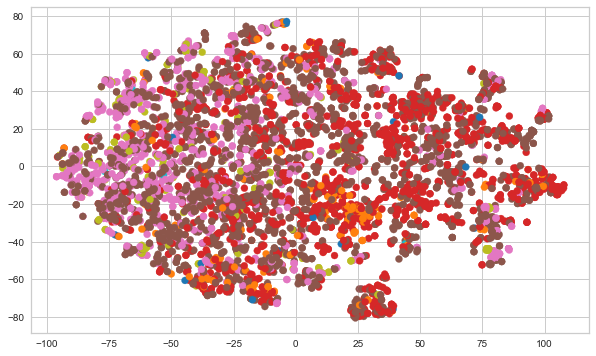

In [170]:
df_tsne = df2[ df2['type'] == 'White' ]
color = df_tsne['quality']
df_tsne.drop(columns=['type', 'quality'], inplace=True)
X_embedded = TSNE(n_components=2, init='pca').fit_transform( StandardScaler().fit_transform(df_tsne) )
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color, cmap='tab10')

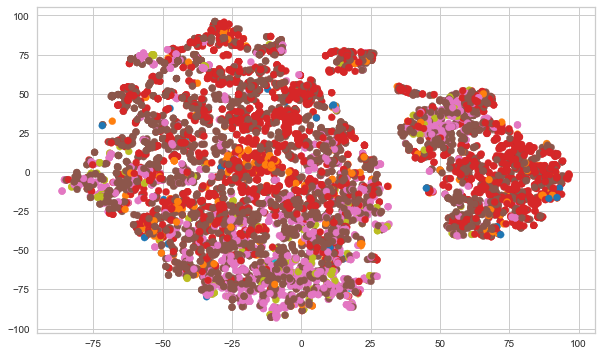

In [179]:
df_tsne = pd.get_dummies(df2)
color = df_tsne['quality']
df_tsne = df_tsne.drop(columns=[ 'quality'])
X_embedded = TSNE(n_components=2, init='pca').fit_transform( StandardScaler().fit_transform(df_tsne) )
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = color, cmap='tab10')

Da pra ver os 3 clusters, mas os labels são misturados mesmo dentro deles. Mesmo assim vou tentar separar em 3 classes.

In [209]:
pca = PCA()
x_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))


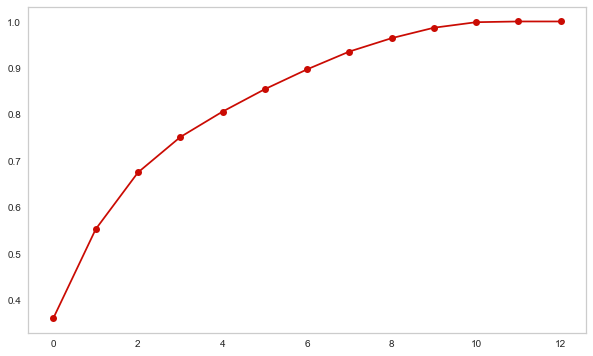

In [210]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()

In [231]:
pca_new = PCA(n_components=8)
X_train_new = pca_new.fit_transform(X_train)
X_test_new = pca_new.fit_transform(X_test)

In [232]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_new,y_train)
tree_pred = decision_tree.predict(X_test_new)

rf = RandomForestClassifier()
rf.fit(X_train_new,y_train)
rf_pred = rf.predict(X_test_new)

KN = KNeighborsClassifier()
KN.fit(X_train_new,y_train)
KN_pred = KN.predict(X_test_new)

Gaussian = GaussianNB()
Gaussian.fit(X_train_new,y_train)
Gaussian_pred = Gaussian.predict(X_test_new)

svc = SVC(kernel = 'rbf')
svc.fit(X_train_new,y_train)
svc_pred = svc.predict(X_test_new)

C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [233]:
print('Decision Tree:', accuracy_score(y_test, tree_pred)*100,'%')
print('Random Forest:', accuracy_score(y_test, rf_pred)*100,'%')
print('KNeighbors:',accuracy_score(y_test, KN_pred)*100,'%')
print('GaussianNB:',accuracy_score(y_test, Gaussian_pred)*100,'%')
print('SVC:',accuracy_score(y_test, svc_pred)*100,'%')


Decision Tree: 42.314990512333964 %
Random Forest: 49.52561669829222 %
KNeighbors: 52.87792536369387 %
GaussianNB: 46.86907020872865 %
SVC: 53.13092979127134 %


Usar PCA piorou.

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


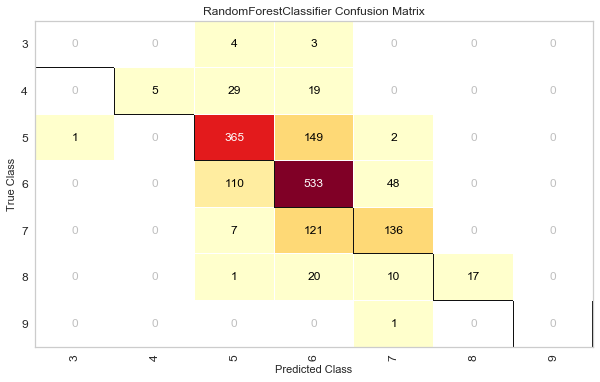

In [236]:
cm = ConfusionMatrix(RandomForestClassifier(random_state=42, n_estimators=100))

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

In [237]:
y_train_new = []
for i in y_train:
    if  i <= 4:
        y_train_new.append('1')
    elif i >= 5 and i <= 6:
        y_train_new.append('2')
    elif i >= 7:
        y_train_new.append('3')

y_test_new = []
for i in y_test:
    if  i <= 4:
        y_test_new.append('1')
    elif i >= 5 and i <= 6:
        y_test_new.append('2')
    elif i >= 7:
        y_test_new.append('3')

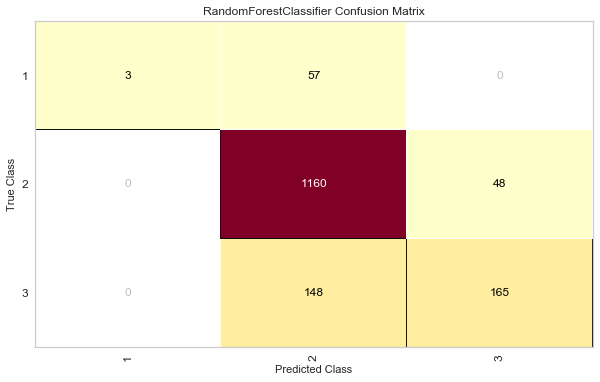

In [239]:
cm = ConfusionMatrix(RandomForestClassifier(random_state=42, n_estimators=100))

cm.fit(X_train, y_train_new)
cm.score(X_test, y_test_new)
cm.poof()

Olha as coisas melhorando. O dataset ainda é bastante desbalanceado, ele ainda bastante notas do tipo 3 agora (7, 8 e 9), mas acertou os vinhos bem ruins (só tinha 3 exemplos) e acertou uns 80% dos vinhos intermediários.

In [240]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train_new)
tree_pred = decision_tree.predict(X_test)

rf = RandomForestClassifier()
rf.fit(X_train,y_train_new)
rf_pred = rf.predict(X_test)

KN = KNeighborsClassifier()
KN.fit(X_train,y_train_new)
KN_pred = KN.predict(X_test)

Gaussian = GaussianNB()
Gaussian.fit(X_train,y_train_new)
Gaussian_pred = Gaussian.predict(X_test)

svc = SVC(kernel = 'rbf')
svc.fit(X_train,y_train_new)
svc_pred = svc.predict(X_test)

print('Decision Tree:', accuracy_score(y_test_new, tree_pred)*100,'%')
print('Random Forest:', accuracy_score(y_test_new, rf_pred)*100,'%')
print('KNeighbors:',accuracy_score(y_test_new, KN_pred)*100,'%')
print('GaussianNB:',accuracy_score(y_test_new, Gaussian_pred)*100,'%')
print('SVC:',accuracy_score(y_test_new, svc_pred)*100,'%')

C:\Users\abner.neto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Decision Tree: 76.91334598355472 %
Random Forest: 82.73244781783681 %
KNeighbors: 80.20240354206199 %
GaussianNB: 64.32637571157495 %
SVC: 78.93738140417457 %


Então resumindo: usar classificação direta não deu certo, métodos de dataset desbalanceados também não, PCA não melhorou. Criar novos labels foi a melhor estratégia até agora e random forest continua o melhor classificador. Meus próximos passos são: (i) testar de novo o balanced classifier, (ii) tentar algum gridsearch e (iii) testar algum outro classificador pra ver se consigo uma acurácia melhor que random forest.

In [245]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train_new) 

y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test_new, y_pred)

0.6687952991181733

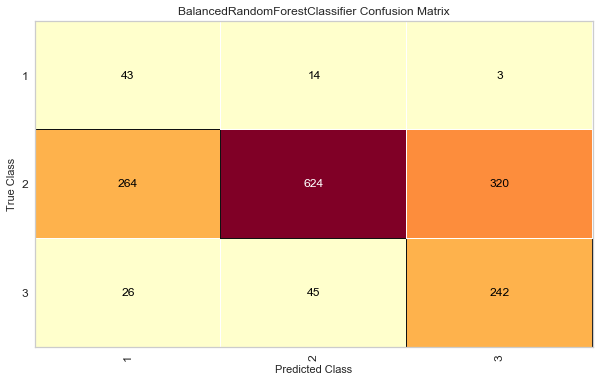

In [247]:
cm = ConfusionMatrix(brf)

cm.fit(X_train, y_train_new)
cm.score(X_test, y_test_new)
cm.poof()

Balanced classifier não deu muito certo, eu posso tentar encontrar o quanto deveria penalizar o erro de cada classe, mas acho que nesse exemplo não vale o trabalho.

In [250]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
rf_random.fit(X_train, y_train_new)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [251]:
print(rf_random.best_params_)

{'n_estimators': 445, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 17, 'bootstrap': False}


In [253]:
model = rf_random.best_estimator_
model_pred = model.predict(X_test)
print('Random Forest:', accuracy_score(y_test_new, model_pred)*100,'%')

Random Forest: 83.1752055660974 %


Testei um random search ao invés do gridsearch com receio de demorar muito. A acurácia ficou nos 83%

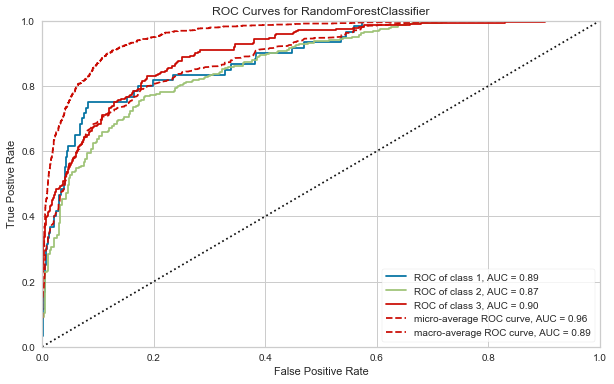

In [273]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train_new) 
visualizer.score(X_test, y_test_new) 
visualizer.poof()   

In [274]:
estimator = lgb.LGBMClassifier(eval_metric='multi_logloss')

param_grid = {
    'num_leaves':[10, 20, 30, 40],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train_new)

print('Best parameters found by grid search are:', gbm.best_params_)
model_gbm = gbm.best_estimator_


Best parameters found by grid search are: {'learning_rate': 1, 'n_estimators': 40, 'num_leaves': 30}


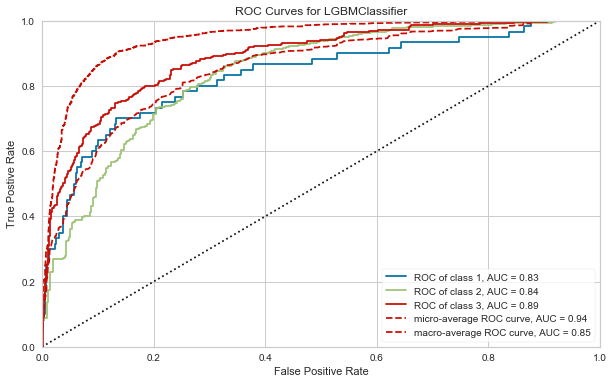

In [276]:
visualizer = ROCAUC(model_gbm)

visualizer.fit(X_train, y_train_new) 
visualizer.score(X_test, y_test_new) 
visualizer.poof()   

In [277]:
model_pred = model_gbm.predict(X_test)
print('Light GBM:', accuracy_score(y_test_new, model_pred)*100,'%')

Light GBM: 83.30170777988614 %


LightGBM também conseguiu um resultado similar a RandomForest. Acho que pra ir na direção de resultados melhores o que poderia ser feito é: (i) testar possíveis combinações entre variáveis (por exemplo, em um dataset clássico do titanic, sabe-se que a criação de novas variáveis através de multiplicação de outras variáveis leva a um desempenho melhor do classificador) (ii) investir em outros modelos e talvez usar os métodos de ensemble do sklearn